In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import minmax_scale  
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.lines import Line2D


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
import os



In [2]:
# Defining dataset and browsing content
data = pd.read_csv('https://raw.githubusercontent.com/tleitch/BDML/main/ErrorModel/errors.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 10 columns):
var 1      124 non-null float64
var 2      124 non-null float64
var 3      124 non-null float64
var 4      124 non-null int64
var 5      124 non-null int64
var 6      124 non-null float64
var 7      124 non-null int64
var 8      124 non-null float64
var 9      124 non-null float64
Outcome    124 non-null int64
dtypes: float64(6), int64(4)
memory usage: 9.8 KB


In [3]:
data.head()

,var 1,var 2,var 3,var 4,var 5,var 6,var 7,var 8,var 9,Outcome
0,0.653573,258.855037,22.999826,1,71,1.240224,2,21.472308,-0.405010,1
1,0.576011,270.889712,23.748059,1,76,1.175028,3,21.123431,0.611585,0
2,0.657729,281.479553,24.914027,2,81,1.177164,1,19.483365,1.054139,0
3,0.546925,302.548908,22.341946,2,76,1.187526,1,20.837815,0.253949,0
4,0.569086,258.731574,22.351487,1,72,1.296652,1,20.409844,0.903367,0


This data is pretty clean from the case authors. Looks like missing is taken care of, the data has been pre-balanced by some algorithm. Only thing we might want to do before using it is standardize/normalize. let's create an X and y for working with the data.

In [4]:
X=data.iloc[0:,0:9]
X.tail()

,var 1,var 2,var 3,var 4,var 5,var 6,var 7,var 8,var 9
119,0.636953,299.510831,22.146210,2,81,1.242409,2,21.448554,-0.382400
120,0.627258,259.353564,23.078033,1,83,1.239721,1,19.630472,-0.164600
121,0.544155,299.066928,25.308636,2,82,1.224124,1,21.104548,1.548561
122,0.643878,275.315415,23.123910,1,79,1.226226,3,20.911596,-0.734790
123,0.603712,277.675805,22.363775,2,73,1.187769,3,20.601871,0.061978


In [5]:
y=data["Outcome"]
y.head()

0    1
1    0
2    0
3    0
4    0
Name: Outcome, dtype: int64

Var 4, var 5, and var 7 all look like they might be categorical factors, let's check

In [6]:
X["var 4"].unique()

array([1, 2], dtype=int64)

In [7]:
X["var 5"].unique()

array([71, 76, 81, 72, 88, 80, 85, 82, 70, 78, 90, 79, 77, 73, 83, 86, 89,
       84, 87, 74, 75], dtype=int64)

In [8]:
X["var 7"].unique()

array([2, 3, 1], dtype=int64)

Yep, these 3 variables will need 1 hot encoding

In [9]:
data=X.copy()
data = pd.get_dummies(data,prefix=['var 4'], columns = ['var 4'])
data = pd.get_dummies(data,prefix=['var 5'], columns = ['var 5'])
data = pd.get_dummies(data,prefix=['var 7'], columns = ['var 7'])
Xencd=data
Xencd.head()


,var 1,var 2,var 3,var 6,var 8,var 9,var 4_1,var 4_2,var 5_70,var 5_71,...,var 5_84,var 5_85,var 5_86,var 5_87,var 5_88,var 5_89,var 5_90,var 7_1,var 7_2,var 7_3
0,0.653573,258.855037,22.999826,1.240224,21.472308,-0.405010,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0.576011,270.889712,23.748059,1.175028,21.123431,0.611585,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.657729,281.479553,24.914027,1.177164,19.483365,1.054139,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.546925,302.548908,22.341946,1.187526,20.837815,0.253949,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.569086,258.731574,22.351487,1.296652,20.409844,0.903367,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Let's create train test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(Xencd, y, test_size=0.25, random_state=42)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (93, 32)
y_train (93,)
X_test (31, 32)
y_test (31,)


In [11]:
# Functions

# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    

In [12]:
# Create RF classification model with GridSearchCV
# n_estimators: The number of trees in the forest.
# criterion, min_samples_split and min_samples_leaf are same to decision tree parameters.
rf_grid = {"n_estimators": [50, 100], "criterion": ["gini", "entropy"],
           "min_samples_split":[3,4,5,6,7], "min_samples_leaf":[1,2,3,4,5,6]}
rforest = GridSearchCV(RandomForestClassifier(random_state=42), rf_grid, cv=5, iid=False)
rforest.fit(X_train, y_train)

print("RF Tuned Hyperparameters", rforest.best_params_)
print("RF Tuned Best Score:", round(rforest.best_score_,3))

RF Tuned Hyperparameters {'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
RF Tuned Best Score: 0.839


In [13]:
best_clf_rforest = rforest.best_estimator_
best_clf_rforest.fit(X_train, y_train)
rforest_y_head = best_clf_rforest.predict(X_test)
print("Random Forest (RF) Classification Accuracy: {}%" .format(round(best_clf_rforest.score(X_test, y_test)*100,2)))

Random Forest (RF) Classification Accuracy: 93.55%


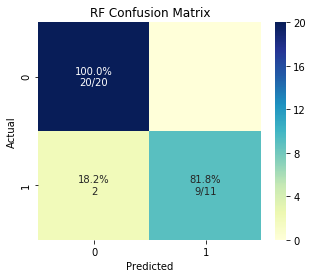

In [14]:
plot_cm(y_test, rforest_y_head, title="RF Confusion Matrix")

To get you started on the HW contest, here is an xgboost model implemented w/o tuning.

In [15]:
from xgboost import XGBClassifier
xgbModel=XGBClassifier()
xgbModel.fit(X_train, y_train)
xgbModel_y_head = xgbModel.predict(X_test)
print("XGB  Classification Accuracy: {}%" .format(round(xgbModel.score(X_test, y_test)*100,2)))

D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:17:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB  Classification Accuracy: 77.42%


D:\Anaconda\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an arr

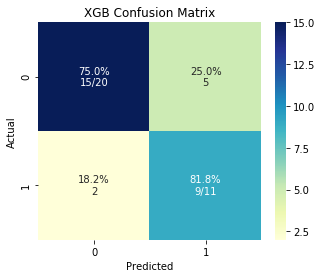

In [16]:
plot_cm(y_test, xgbModel_y_head, title="XGB Confusion Matrix")

<h1>Grid Search Tuning</h1>

In [17]:
#Initalization & n_estimators tuning
param_test1 = {
 'n_estimators':[10, 15, 20, 30, 50, 80, 100]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(         learning_rate =0.1, n_estimators=100, max_depth=5,
min_child_weight=1, gamma=0, subsample=0.8,             colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4,     scale_pos_weight=1, seed=27), 
 param_grid = param_test1,     scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.grid_scores_, gsearch1.best_params_,     gsearch1.best_score_

D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:17:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86981, std: 0.11673, params: {'n_estimators': 10},
  mean: 0.85357, std: 0.13628, params: {'n_estimators': 15},
  mean: 0.87792, std: 0.10421, params: {'n_estimators': 20},
  mean: 0.88474, std: 0.10292, params: {'n_estimators': 30},
  mean: 0.87468, std: 0.11204, params: {'n_estimators': 50},
  mean: 0.86494, std: 0.11940, params: {'n_estimators': 80},
  mean: 0.86461, std: 0.12340, params: {'n_estimators': 100}],
 {'n_estimators': 30},
 0.8847402597402597)

In [18]:
#max_depth & min_child_weight
param_test2 = {
 'max_depth':[3,4,5,6,7],
 'min_child_weight':[1,2,3,4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(         learning_rate =0.1, n_estimators=30, max_depth=5,
min_child_weight=1, gamma=0, subsample=0.8,             colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4,     scale_pos_weight=1, seed=27), 
 param_grid = param_test2,     scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train, y_train)
gsearch2.grid_scores_, gsearch2.best_params_,     gsearch2.best_score_

[20:18:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.89383, std: 0.10563, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.87565, std: 0.13028, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.85032, std: 0.12081, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.82857, std: 0.13173, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.58279, std: 0.13624, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.52679, std: 0.04213, params: {'max_depth': 3, 'min_child_weight': 6},
  mean: 0.88474, std: 0.10441, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.87597, std: 0.12538, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.85032, std: 0.12081, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.82857, std: 0.13173, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.58279, std: 0.13624, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.52679, std: 0.04213, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: 0.88474, std: 0.10292, params: {

In [19]:
#gamma
param_test3 = {
 'gamma':[i/10.0 for i in range(0,10)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(         learning_rate =0.1, n_estimators=30, max_depth=3,
min_child_weight=1, gamma=0, subsample=0.8,             colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4,     scale_pos_weight=1, seed=27), 
 param_grid = param_test3,     scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train, y_train)
gsearch3.grid_scores_, gsearch3.best_params_,     gsearch3.best_score_

[20:18:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.89383, std: 0.10563, params: {'gamma': 0.0},
  mean: 0.89156, std: 0.10807, params: {'gamma': 0.1},
  mean: 0.88929, std: 0.11063, params: {'gamma': 0.2},
  mean: 0.89416, std: 0.10482, params: {'gamma': 0.3},
  mean: 0.89416, std: 0.10845, params: {'gamma': 0.4},
  mean: 0.89351, std: 0.11010, params: {'gamma': 0.5},
  mean: 0.89870, std: 0.10683, params: {'gamma': 0.6},
  mean: 0.90130, std: 0.10368, params: {'gamma': 0.7},
  mean: 0.89091, std: 0.11713, params: {'gamma': 0.8},
  mean: 0.88636, std: 0.11499, params: {'gamma': 0.9}],
 {'gamma': 0.7},
 0.9012987012987013)

In [20]:
#subsample & colsample_bytree
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(3,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(         learning_rate =0.1, n_estimators=30, max_depth=3,
min_child_weight=1, gamma=0.7, subsample=0.8,             colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4,     scale_pos_weight=1, seed=27), 
 param_grid = param_test4,     scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train, y_train)
gsearch4.grid_scores_, gsearch4.best_params_,     gsearch4.best_score_

[20:18:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.87208, std: 0.08472, params: {'colsample_bytree': 0.3, 'subsample': 0.6},
  mean: 0.87110, std: 0.10503, params: {'colsample_bytree': 0.3, 'subsample': 0.7},
  mean: 0.90455, std: 0.09561, params: {'colsample_bytree': 0.3, 'subsample': 0.8},
  mean: 0.88766, std: 0.10019, params: {'colsample_bytree': 0.3, 'subsample': 0.9},
  mean: 0.89123, std: 0.08950, params: {'colsample_bytree': 0.4, 'subsample': 0.6},
  mean: 0.89188, std: 0.10077, params: {'colsample_bytree': 0.4, 'subsample': 0.7},
  mean: 0.90260, std: 0.10770, params: {'colsample_bytree': 0.4, 'subsample': 0.8},
  mean: 0.89221, std: 0.11038, params: {'colsample_bytree': 0.4, 'subsample': 0.9},
  mean: 0.88214, std: 0.10534, params: {'colsample_bytree': 0.5, 'subsample': 0.6},
  mean: 0.88929, std: 0.10500, params: {'colsample_bytree': 0.5, 'subsample': 0.7},
  mean: 0.89221, std: 0.09743, params: {'colsample_bytree': 0.5, 'subsample': 0.8},
  mean: 0.88539, std: 0.10922, params: {'colsample_bytree': 0.5, 'subsample'

In [21]:
#reg_alpha & reg_lambda
param_test5 = {
 'reg_alpha':[0, 0.05, 0.1, 0.3, 0.5, 1],
 'reg_lambda': [0, 0.1, 0.5, 0.6, 0.8, 1]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(         learning_rate =0.1, n_estimators=30, max_depth=3,
min_child_weight=1, gamma=0.7, subsample=0.9,             colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4,     scale_pos_weight=1, seed=27), 
 param_grid = param_test5,     scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train, y_train)
gsearch5.grid_scores_, gsearch5.best_params_,     gsearch5.best_score_

[20:18:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.89903, std: 0.10780, params: {'reg_alpha': 0, 'reg_lambda': 0},
  mean: 0.89643, std: 0.10871, params: {'reg_alpha': 0, 'reg_lambda': 0.1},
  mean: 0.89740, std: 0.11617, params: {'reg_alpha': 0, 'reg_lambda': 0.5},
  mean: 0.90455, std: 0.11171, params: {'reg_alpha': 0, 'reg_lambda': 0.6},
  mean: 0.91266, std: 0.09468, params: {'reg_alpha': 0, 'reg_lambda': 0.8},
  mean: 0.90779, std: 0.10061, params: {'reg_alpha': 0, 'reg_lambda': 1},
  mean: 0.89903, std: 0.11036, params: {'reg_alpha': 0.05, 'reg_lambda': 0},
  mean: 0.89740, std: 0.11617, params: {'reg_alpha': 0.05, 'reg_lambda': 0.1},
  mean: 0.89968, std: 0.11448, params: {'reg_alpha': 0.05, 'reg_lambda': 0.5},
  mean: 0.90487, std: 0.10624, params: {'reg_alpha': 0.05, 'reg_lambda': 0.6},
  mean: 0.90260, std: 0.10818, params: {'reg_alpha': 0.05, 'reg_lambda': 0.8},
  mean: 0.89740, std: 0.11617, params: {'reg_alpha': 0.05, 'reg_lambda': 1},
  mean: 0.89383, std: 0.11310, params: {'reg_alpha': 0.1, 'reg_lambda': 0},
  

In [22]:
#learning_rate
param_test6 = {
 'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.15, 0.2]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(         learning_rate =0.1, n_estimators=30, max_depth=3,
min_child_weight=1, gamma=0.7, subsample=0.9,             colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4,     scale_pos_weight=1, seed=27, reg_alpha=0, reg_lambda=0.8), 
 param_grid = param_test6,     scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train, y_train)
gsearch6.grid_scores_, gsearch6.best_params_,     gsearch6.best_score_

[20:18:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85455, std: 0.13299, params: {'learning_rate': 0.01},
  mean: 0.89188, std: 0.10410, params: {'learning_rate': 0.05},
  mean: 0.90032, std: 0.11026, params: {'learning_rate': 0.07},
  mean: 0.91266, std: 0.09468, params: {'learning_rate': 0.1},
  mean: 0.89253, std: 0.10575, params: {'learning_rate': 0.15},
  mean: 0.88766, std: 0.12130, params: {'learning_rate': 0.2}],
 {'learning_rate': 0.1},
 0.9126623376623376)

In [23]:
#Best model
xgb = XGBClassifier(
     learning_rate =0.1,
     n_estimators=30,
     max_depth=3,
     min_child_weight=1,
     gamma=0.7,
     subsample=0.9,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     nthread=4,
     scale_pos_weight=1,
     seed=27,
     reg_alpha=0, reg_lambda=0.8)

In [24]:
xgb.fit(X_train, y_train)
xgb_y_head = xgb.predict(X_test)
print("XGB  Classification Accuracy: {}%" .format(round(xgb.score(X_test, y_test)*100,2)))

[20:18:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB  Classification Accuracy: 87.1%


D:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\Anaconda\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda\lib\site-packages\xgboost\data.py

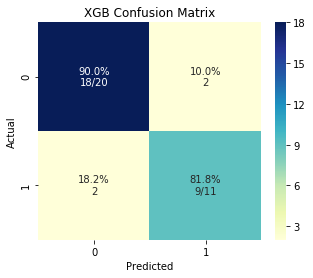

In [25]:
plot_cm(y_test, xgb_y_head, title="XGB Confusion Matrix")

After tuning the parameters, the accuracy of the model is improved from 77.42% to 87.1%